In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [7]:
labels = get_labels('/kaggle/input/labelsssssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [8]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [9]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())
    
    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class
    
    if numbers_per_class[0][1] >= numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]
    
    if max_per_class > max_value//2:
        max_per_class = max_value//2
        
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero <= max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one <= max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [10]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices
        
    return slices

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []

        new_images.append(x.astype('float16'))
        """
        new_images.append(
            ndimage.rotate(x.astype('float32'), angle=10, axes=(1, 0), reshape=False).astype(
                'float16'))
        new_images.append(
            ndimage.rotate(x.astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype(
                'float16'))
        """

        x = cv2.flip(x.astype('float32'), 1).astype('float16')
        new_images.append(np.expand_dims(x, -1))
        """
        new_images.append(
            ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=10, axes=(1, 0), reshape=False).astype(
                'float16'))
        new_images.append(
            ndimage.rotate(np.expand_dims(x, -1).astype('float32'), angle=-10, axes=(1, 0), reshape=False).astype(
                'float16'))
        """

        return new_images

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                    
        X, y = utils.shuffle(X, y)
        return X, y

In [13]:
class InceptionModule(keras.layers.Layer):
    def __init__(self, filters, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a    = keras.layers.Conv2D(filters[0], kernel_size=(1,1), padding='same', use_bias='false', strides=1)
        self.bn_a      = keras.layers.BatchNormalization()
        
        self.conv_b1   = keras.layers.Conv2D(filters[1], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.conv_b2   = keras.layers.Conv2D(filters[2], kernel_size=(3, 4), padding='same', use_bias='false', strides=1)
        self.bn_b      = keras.layers.BatchNormalization()
        
        self.conv_c1   = keras.layers.Conv2D(filters[3], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.conv_c2   = keras.layers.Conv2D(filters[4], kernel_size=(6, 8), padding='same', use_bias='false', strides=1)
        self.bn_c      = keras.layers.BatchNormalization()
        
        self.maxpool_d = keras.layers.MaxPooling2D(pool_size=(3, 4), padding='same', strides=1)
        self.conv_d    = keras.layers.Conv2D(filters[5], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.bn_d      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a(x)
        out1 = self.bn_a(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c(out3)
        out3 = self.activation(out3)
        
        out4 = self.maxpool_d(x)
        out4 = self.conv_d(out4)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)

def get_googlenet():
    GoogLeNet = keras.Sequential()

    GoogLeNet.add(keras.layers.Conv2D(filters=64, kernel_size=(6, 8), strides=2, padding='same', input_shape=(192, 256, 1)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same'))
    GoogLeNet.add(keras.layers.Conv2D(filters=192, kernel_size=(3, 4), strides=1, padding='same'))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(InceptionModule([128, 128, 192, 32, 96, 64]))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([192, 96, 208, 16, 48, 64]))
    GoogLeNet.add(InceptionModule([160, 112, 224, 24, 64, 64]))
    GoogLeNet.add(InceptionModule([128, 128, 256, 24, 64, 64]))
    GoogLeNet.add(InceptionModule([112, 144, 288, 32, 64, 64]))
    GoogLeNet.add(InceptionModule([256, 160, 320, 32, 128, 128]))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(keras.layers.GlobalAveragePooling2D())
    GoogLeNet.add(keras.layers.Dropout(0.4))
    GoogLeNet.add(keras.layers.Dense(1024, activation='relu'))
    GoogLeNet.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return GoogLeNet

In [10]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=256,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()    
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(1e-5),
                     metrics=[keras.metrics.AUC(name='AUC'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=50,
                                   use_multiprocessing=True,
                                   workers=1))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/50
31/31 [==============================] - 123s 3s/step - loss: 0.7054 - AUC: 0.5098 - accuracy: 0.4907 - precision: 0.4735 - recall: 0.1792 - val_loss: 0.6993 - val_AUC: 0.5000 - val_accuracy: 0.3400 - val_precision: 0.3400 - val_recall: 1.0000
Epoch 2/50
31/31 [==============================] - 57s 2s/step - loss: 0.6898 - AUC: 0.5802 - accuracy: 0.5446 - precision: 0.6033 - recall: 0.2573 - val_loss: 0.7014 - val_AUC: 0.5899 - val_accuracy: 0.3400 - val_precision: 0.3400 - val_recall: 1.0000
Epoch 3/50
31/31 [==============================] - 59s 2s/step - loss: 0.6726 - AUC: 0.6634 - accuracy: 0.5672 - precision: 0.6963 - recall: 0.2361 - val_loss: 0.7001 - val_AUC: 0.5000 - val_accuracy: 0.3400 - val_precision: 0.3400 - val_recall: 1.0000
Epoch 4/50
31/31 [==============================] - 59s 2s/step - loss: 0.6659 - AUC: 0.6852 - accuracy: 0.5881 - precision: 0.7041 - recall: 0.3027 - val_loss: 0.7109 - val_AUC: 0.7280 - val_accuracy: 0.3400 - val_precision: 

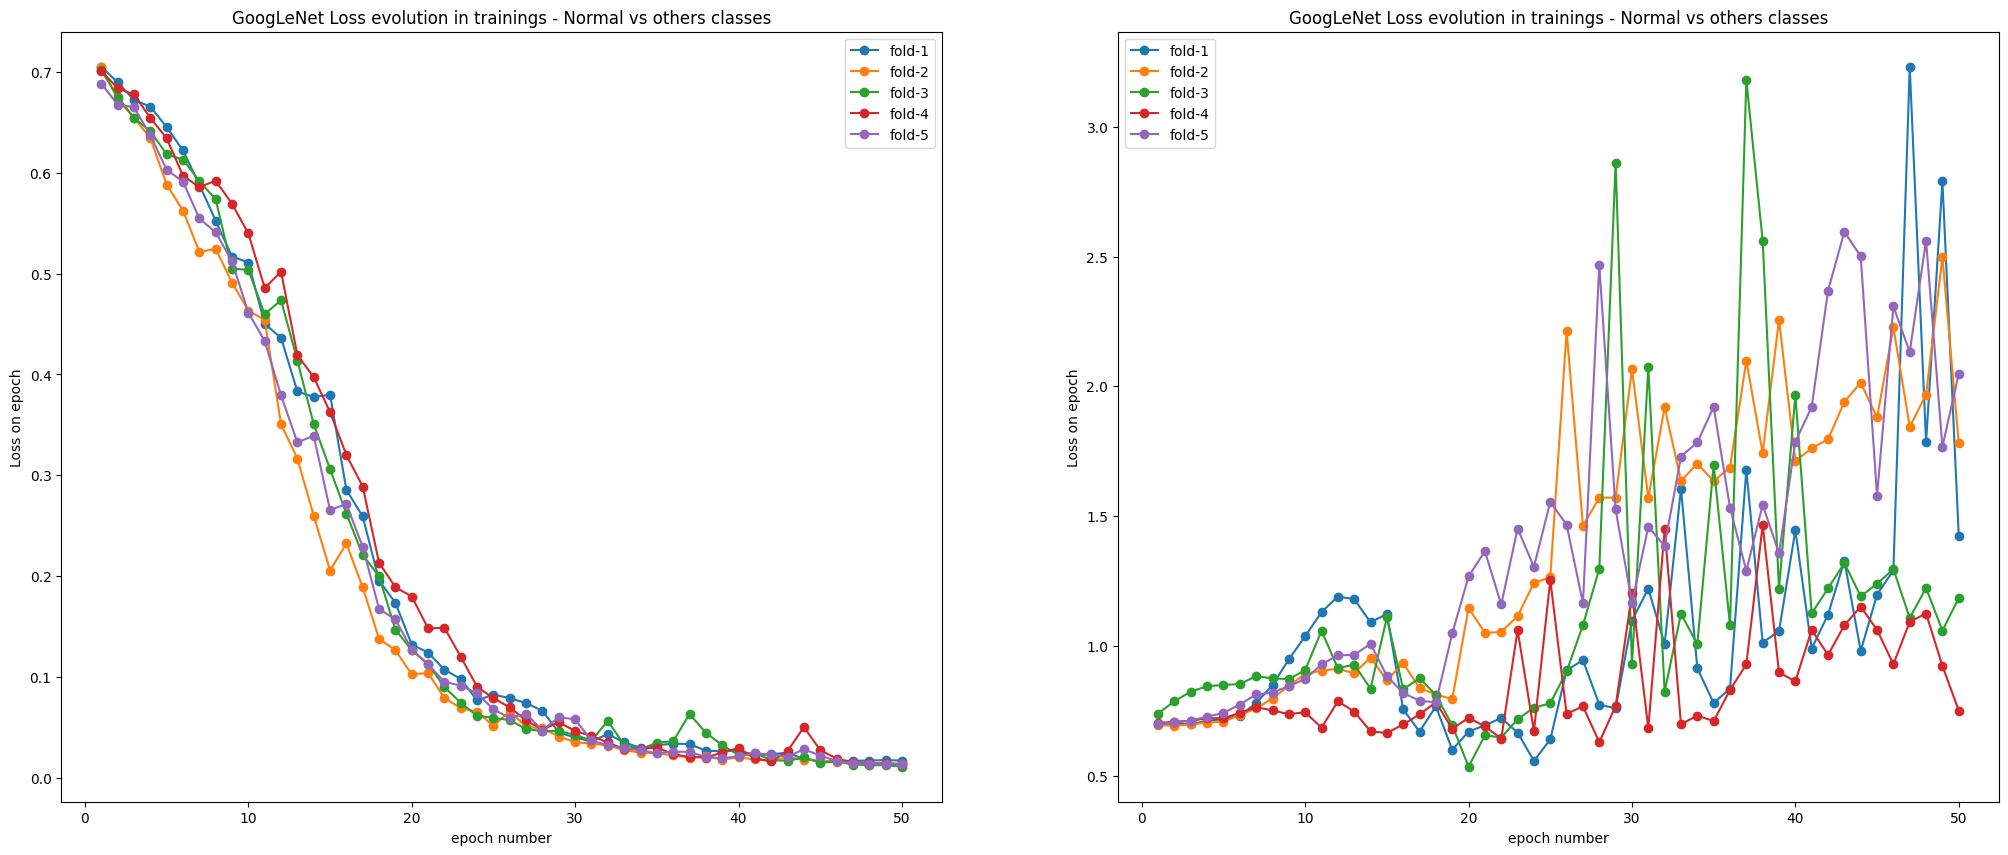

In [39]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 51)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(1, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 51)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [50]:
print('Best results in validations for any k-fold: ')
means = [0, 0, 0, 0]
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history['AUC'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history['accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history['precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history['recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history['val_AUC'])
    means[0] += k
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history['val_accuracy'])
    means[1] += k
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history['val_precision'])
    means[2] += k
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history['val_recall'])
    means[3] += k
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

print(f"Average best AUC: {means[0]/5}")
print(f"Average best Accuracy: {means[1]/5}")
print(f"Average best Precision: {means[2]/5}")
print(f"Average best Recall: {means[3]/5}")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7774034738540649
Best Accuracy in validation: 0.7323151230812073
Best Precision in validation: 0.7008928656578064
Best Recall in validation: 1.0



K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5716826915740967
Best Accuracy in validation: 0.6849100589752197
Best Precision in validation: 0.3767705261707306
Best Recall in validation: 1.0



K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6805438995361328
Best Accuracy in validation: 0.8292490243911743
Best Precision in validation: 0.8983

In [18]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=256,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()    
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(1e-5),
                     metrics=[keras.metrics.AUC(name='AUC'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=65,
                                   use_multiprocessing=True,
                                   workers=1))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/65
31/31 [==============================] - 113s 2s/step - loss: 0.6983 - AUC: 0.5441 - accuracy: 0.5164 - precision: 0.5714 - recall: 0.0990 - val_loss: 0.6731 - val_AUC: 0.5000 - val_accuracy: 0.8714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/65
31/31 [==============================] - 50s 2s/step - loss: 0.7108 - AUC: 0.6205 - accuracy: 0.5076 - precision: 0.7000 - recall: 0.0083 - val_loss: 0.6166 - val_AUC: 0.5000 - val_accuracy: 0.8714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/65
31/31 [==============================] - 51s 2s/step - loss: 0.7250 - AUC: 0.6731 - accuracy: 0.5041 - precision: 0.5000 - recall: 0.0010 - val_loss: 0.5667 - val_AUC: 0.5000 - val_accuracy: 0.8714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/65
31/31 [==============================] - 52s 2s/step - loss: 0.7329 - AUC: 0.7360 - accuracy: 0.5036 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5360 - val_AUC: 0.4972 - val_ac

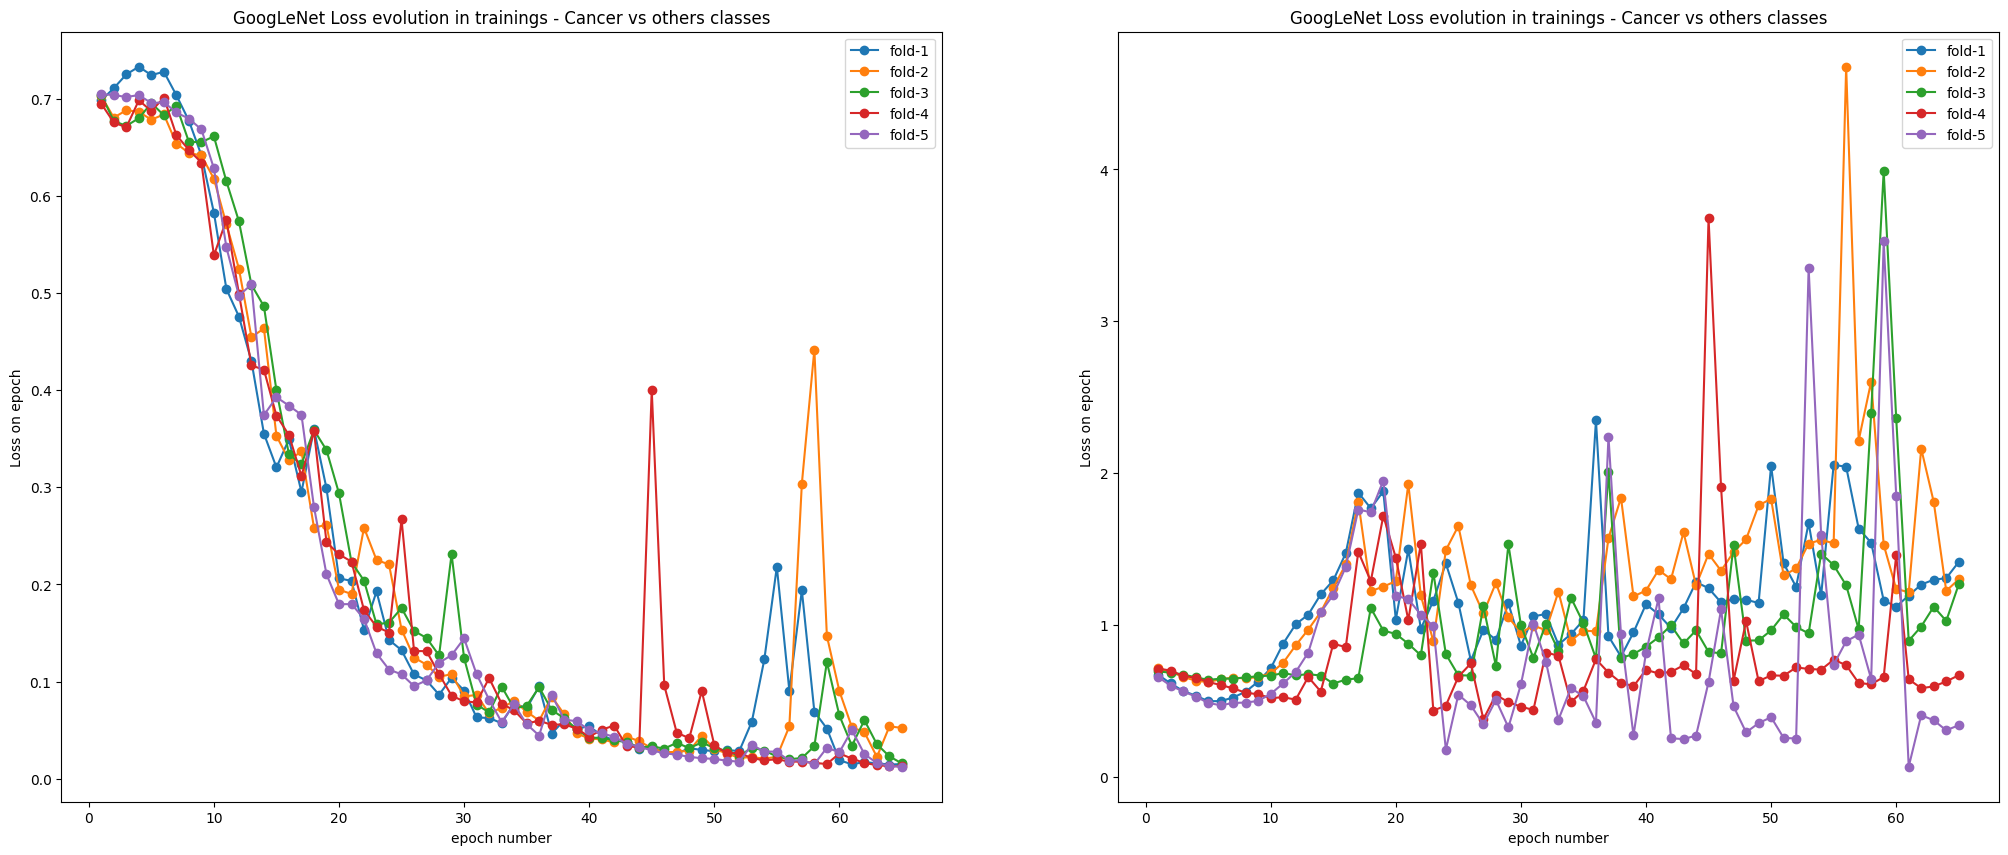

In [19]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 66)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(1, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 66)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [20]:
print('Best results in validations for any k-fold: ')
means = [0, 0, 0, 0]
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history['AUC'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history['accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history['precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history['recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history['val_AUC'])
    means[0] += k
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history['val_accuracy'])
    means[1] += k
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history['val_precision'])
    means[2] += k
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history['val_recall'])
    means[3] += k
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

print(f"Average best AUC: {means[0]/5}")
print(f"Average best Accuracy: {means[1]/5}")
print(f"Average best Precision: {means[2]/5}")
print(f"Average best Recall: {means[3]/5}")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6614593863487244
Best Accuracy in validation: 0.8713826537132263
Best Precision in validation: 0.17201165854930878
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6663901805877686
Best Accuracy in validation: 0.8788115978240967
Best Precision in validation: 0.2222222238779068
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.8087068796157837
Best Accuracy in validation: 0.8300395011901855
Best Precision in vali

In [10]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=256,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()    
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(1e-5),
                     metrics=[keras.metrics.AUC(name='AUC'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=55,
                                   use_multiprocessing=True,
                                   workers=1))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/55
31/31 [==============================] - 125s 3s/step - loss: 0.6983 - AUC: 0.5216 - accuracy: 0.5197 - precision: 0.5124 - recall: 0.7792 - val_loss: 0.6961 - val_AUC: 0.5000 - val_accuracy: 0.3006 - val_precision: 0.3006 - val_recall: 1.0000
Epoch 2/55
31/31 [==============================] - 56s 2s/step - loss: 0.6756 - AUC: 0.6151 - accuracy: 0.5772 - precision: 0.5890 - recall: 0.5046 - val_loss: 0.6823 - val_AUC: 0.5000 - val_accuracy: 0.6994 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/55
31/31 [==============================] - 57s 2s/step - loss: 0.6585 - AUC: 0.7017 - accuracy: 0.5936 - precision: 0.7009 - recall: 0.3228 - val_loss: 0.6603 - val_AUC: 0.5000 - val_accuracy: 0.6994 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/55
31/31 [==============================] - 57s 2s/step - loss: 0.6431 - AUC: 0.7777 - accuracy: 0.6040 - precision: 0.8317 - recall: 0.2593 - val_loss: 0.6444 - val_AUC: 0.5000 - val_accuracy: 0.6994 -

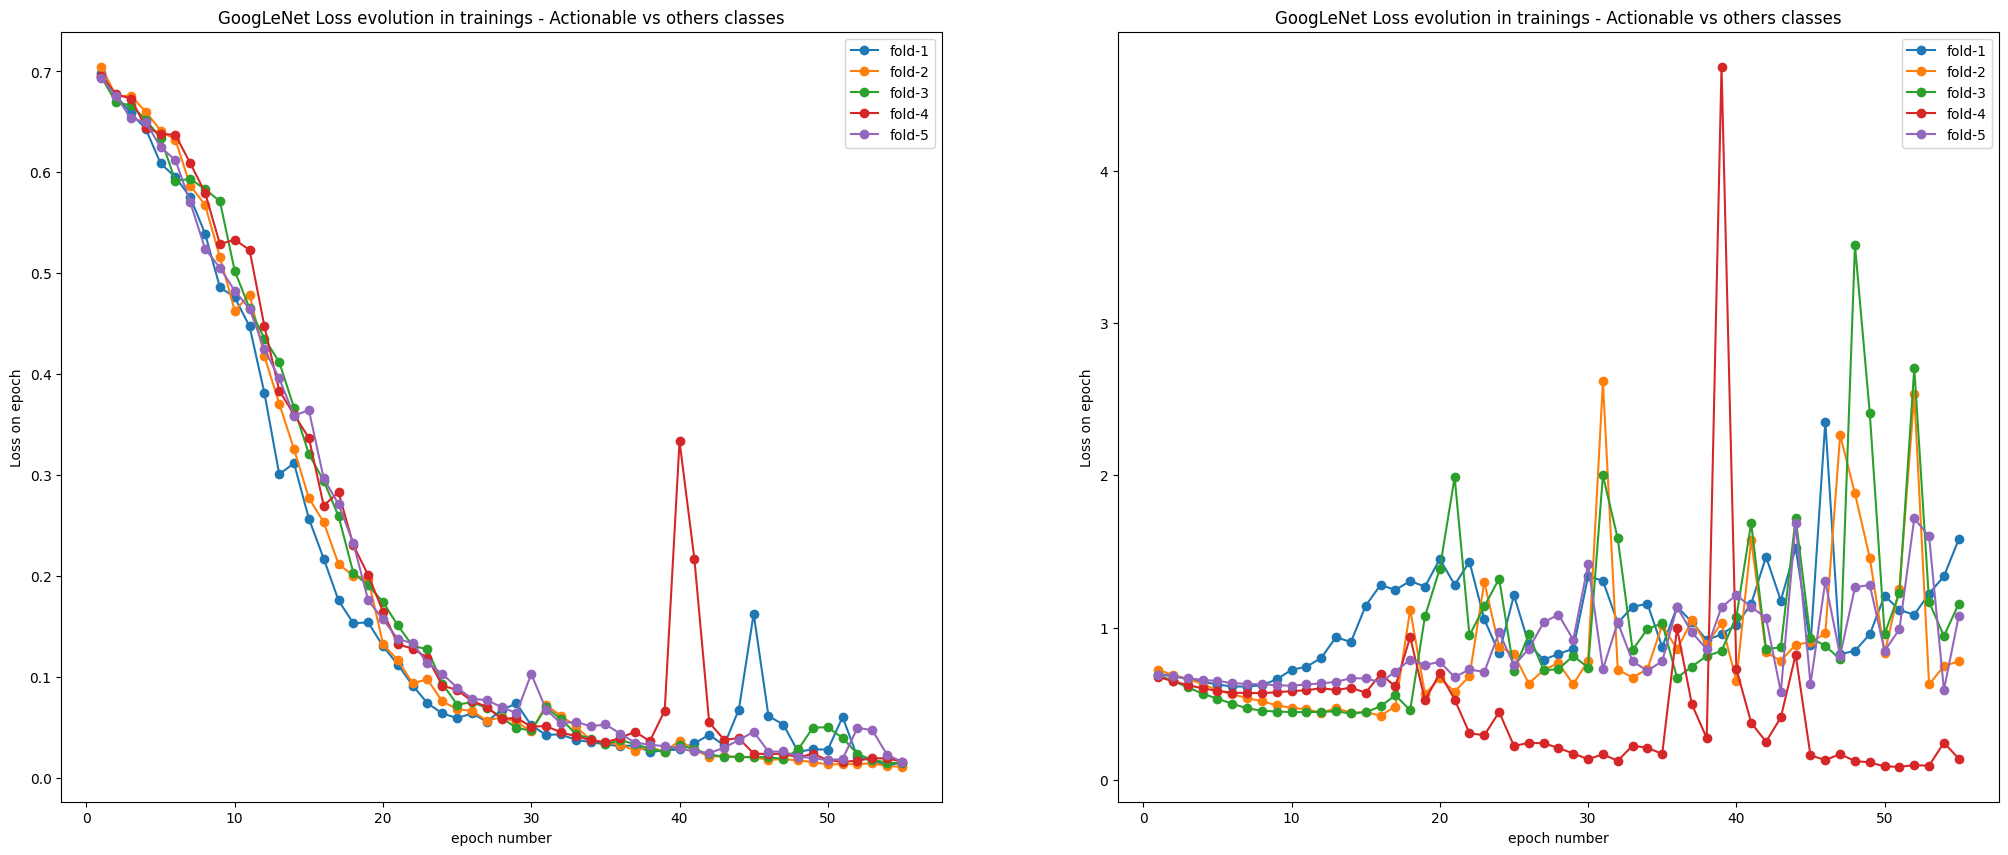

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 56)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(1, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 56)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [13]:
print('Best results in validations for any k-fold: ')
means = [0, 0, 0, 0]
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history['AUC'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history['accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history['precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history['recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history['val_AUC'])
    means[0] += k
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history['val_accuracy'])
    means[1] += k
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history['val_precision'])
    means[2] += k
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history['val_recall'])
    means[3] += k
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

print(f"Average best AUC: {means[0]/5}")
print(f"Average best Accuracy: {means[1]/5}")
print(f"Average best Precision: {means[2]/5}")
print(f"Average best Recall: {means[3]/5}")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.8006992340087891
Best Accuracy in validation: 0.8094855546951294
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6813461184501648
Best Accuracy in validation: 0.857701301574707
Best Precision in validation: 0.22289156913757324
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6447882652282715
Best Accuracy in validation: 0.8837944865226746
Best Precision in validation: 1.0
Best

In [14]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=256,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()    
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(1e-5),
                     metrics=[keras.metrics.AUC(name='AUC'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=60,
                                   use_multiprocessing=True,
                                   workers=1))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/60
31/31 [==============================] - 78s 1s/step - loss: 0.7103 - AUC: 0.4431 - accuracy: 0.4664 - precision: 0.4597 - recall: 0.3978 - val_loss: 0.7196 - val_AUC: 0.5000 - val_accuracy: 0.2307 - val_precision: 0.2307 - val_recall: 1.0000
Epoch 2/60
31/31 [==============================] - 60s 2s/step - loss: 0.6853 - AUC: 0.5929 - accuracy: 0.5272 - precision: 0.5712 - recall: 0.2094 - val_loss: 0.7142 - val_AUC: 0.5000 - val_accuracy: 0.2307 - val_precision: 0.2307 - val_recall: 1.0000
Epoch 3/60
31/31 [==============================] - 59s 2s/step - loss: 0.6694 - AUC: 0.6946 - accuracy: 0.5527 - precision: 0.7541 - recall: 0.1534 - val_loss: 0.6982 - val_AUC: 0.5000 - val_accuracy: 0.2307 - val_precision: 0.2307 - val_recall: 1.0000
Epoch 4/60
31/31 [==============================] - 59s 2s/step - loss: 0.6716 - AUC: 0.7256 - accuracy: 0.5269 - precision: 0.8286 - recall: 0.0639 - val_loss: 0.6712 - val_AUC: 0.4902 - val_accuracy: 0.7693 - val_precision: 0

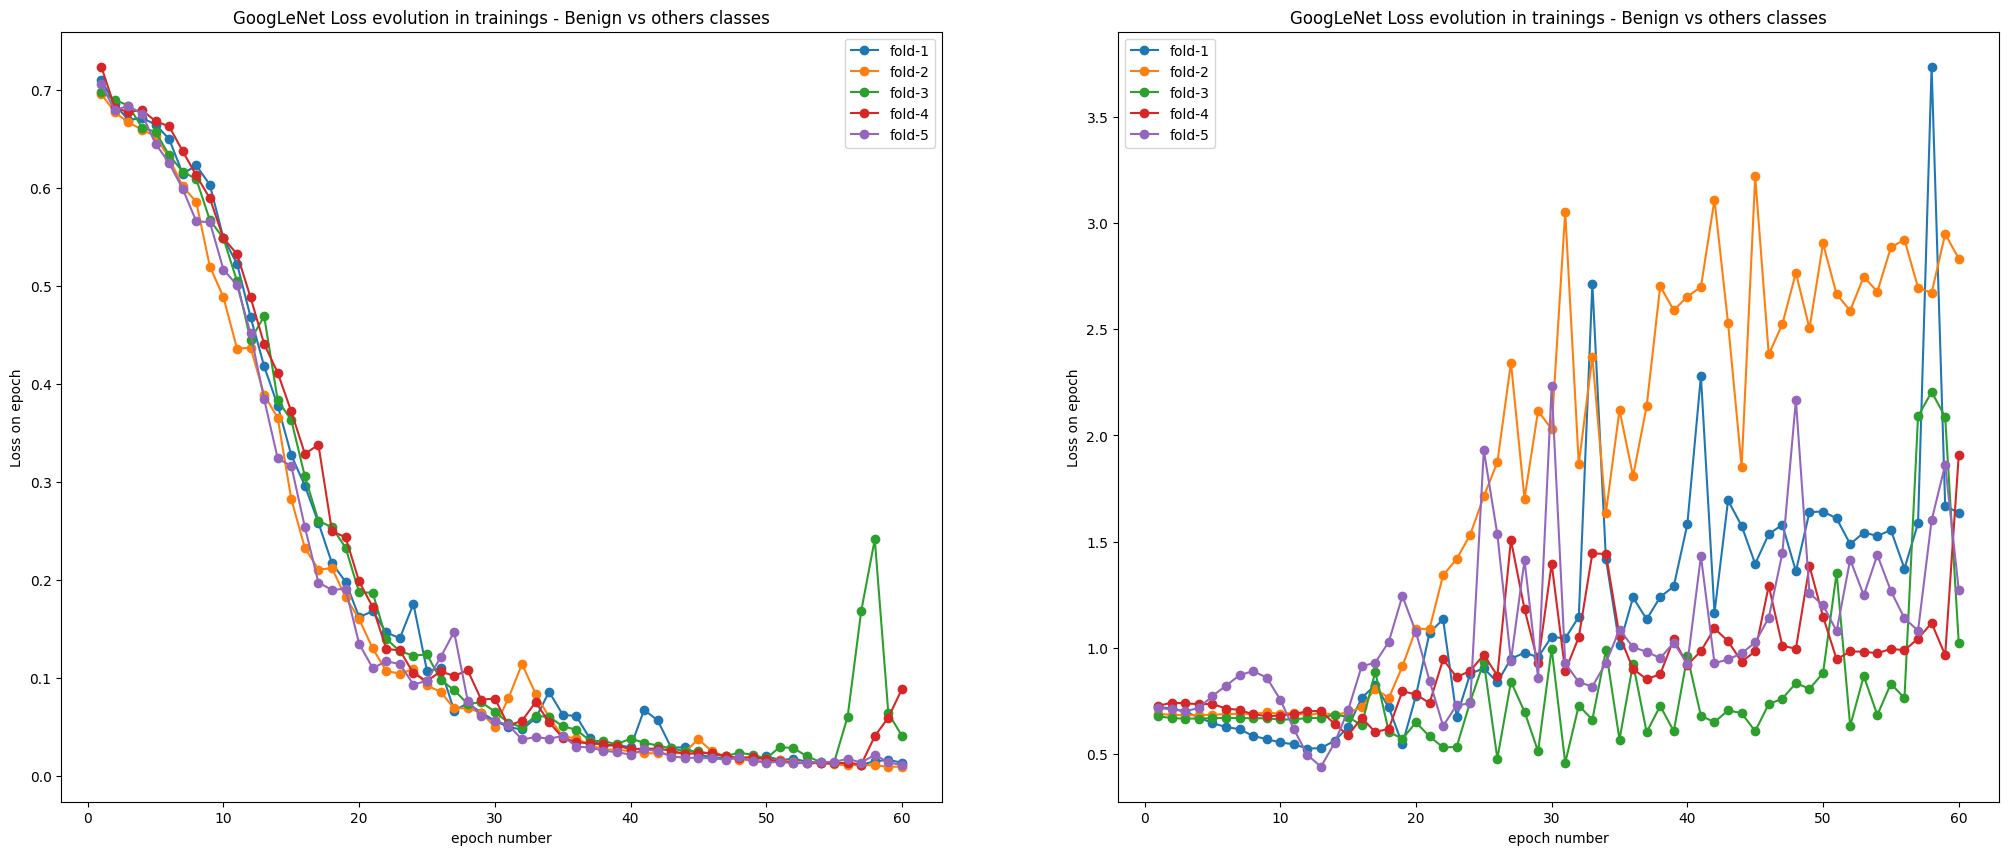

In [16]:
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 61)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(1, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 61)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution in trainings - Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [17]:
print('Best results in validations for any k-fold: ')
means = [0, 0, 0, 0]
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history['AUC'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history['accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history['precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history['recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history['val_AUC'])
    means[0] += k
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history['val_accuracy'])
    means[1] += k
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history['val_precision'])
    means[2] += k
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history['val_recall'])
    means[3] += k
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

print(f"Average best AUC: {means[0]/5}")
print(f"Average best Accuracy: {means[1]/5}")
print(f"Average best Precision: {means[2]/5}")
print(f"Average best Recall: {means[3]/5}")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.8745753765106201
Best Accuracy in validation: 0.7692925930023193
Best Precision in validation: 0.34226804971694946
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5863109230995178
Best Accuracy in validation: 0.5793588757514954
Best Precision in validation: 1.0
Best Recall in validation: 0.8311688303947449


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.900932252407074
Best Accuracy in validation: 0.8300395011901855
Best Precision in valid

In [18]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                   list_IDs=X_train, 
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                   dim_img=(192, 256), 
                                   batch_size=5,
                                   sub_batch_size=256,
                                   shuffle=True, 
                                   training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-5),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])
                                                               

# Train model on dataset
history = googlenet.fit(training_generator, epochs=50)

Epoch 1/50
35/35 [==============================] - 114s 2s/step - loss: 0.7000 - AUC: 0.5057 - accuracy: 0.5156 - precision: 0.5104 - recall: 0.7610
Epoch 2/50
35/35 [==============================] - 47s 1s/step - loss: 0.6568 - AUC: 0.6937 - accuracy: 0.6399 - precision: 0.6617 - recall: 0.5711
Epoch 3/50
35/35 [==============================] - 41s 1s/step - loss: 0.6482 - AUC: 0.7057 - accuracy: 0.6436 - precision: 0.6972 - recall: 0.5068
Epoch 4/50
35/35 [==============================] - 41s 1s/step - loss: 0.6333 - AUC: 0.7320 - accuracy: 0.6583 - precision: 0.7125 - recall: 0.5294
Epoch 5/50
35/35 [==============================] - 42s 1s/step - loss: 0.6056 - AUC: 0.7808 - accuracy: 0.6619 - precision: 0.7443 - recall: 0.4919
Epoch 6/50
35/35 [==============================] - 40s 1s/step - loss: 0.5799 - AUC: 0.8209 - accuracy: 0.6992 - precision: 0.8243 - recall: 0.5053
Epoch 7/50
35/35 [==============================] - 40s 1s/step - loss: 0.5571 - AUC: 0.8392 - accuracy: 

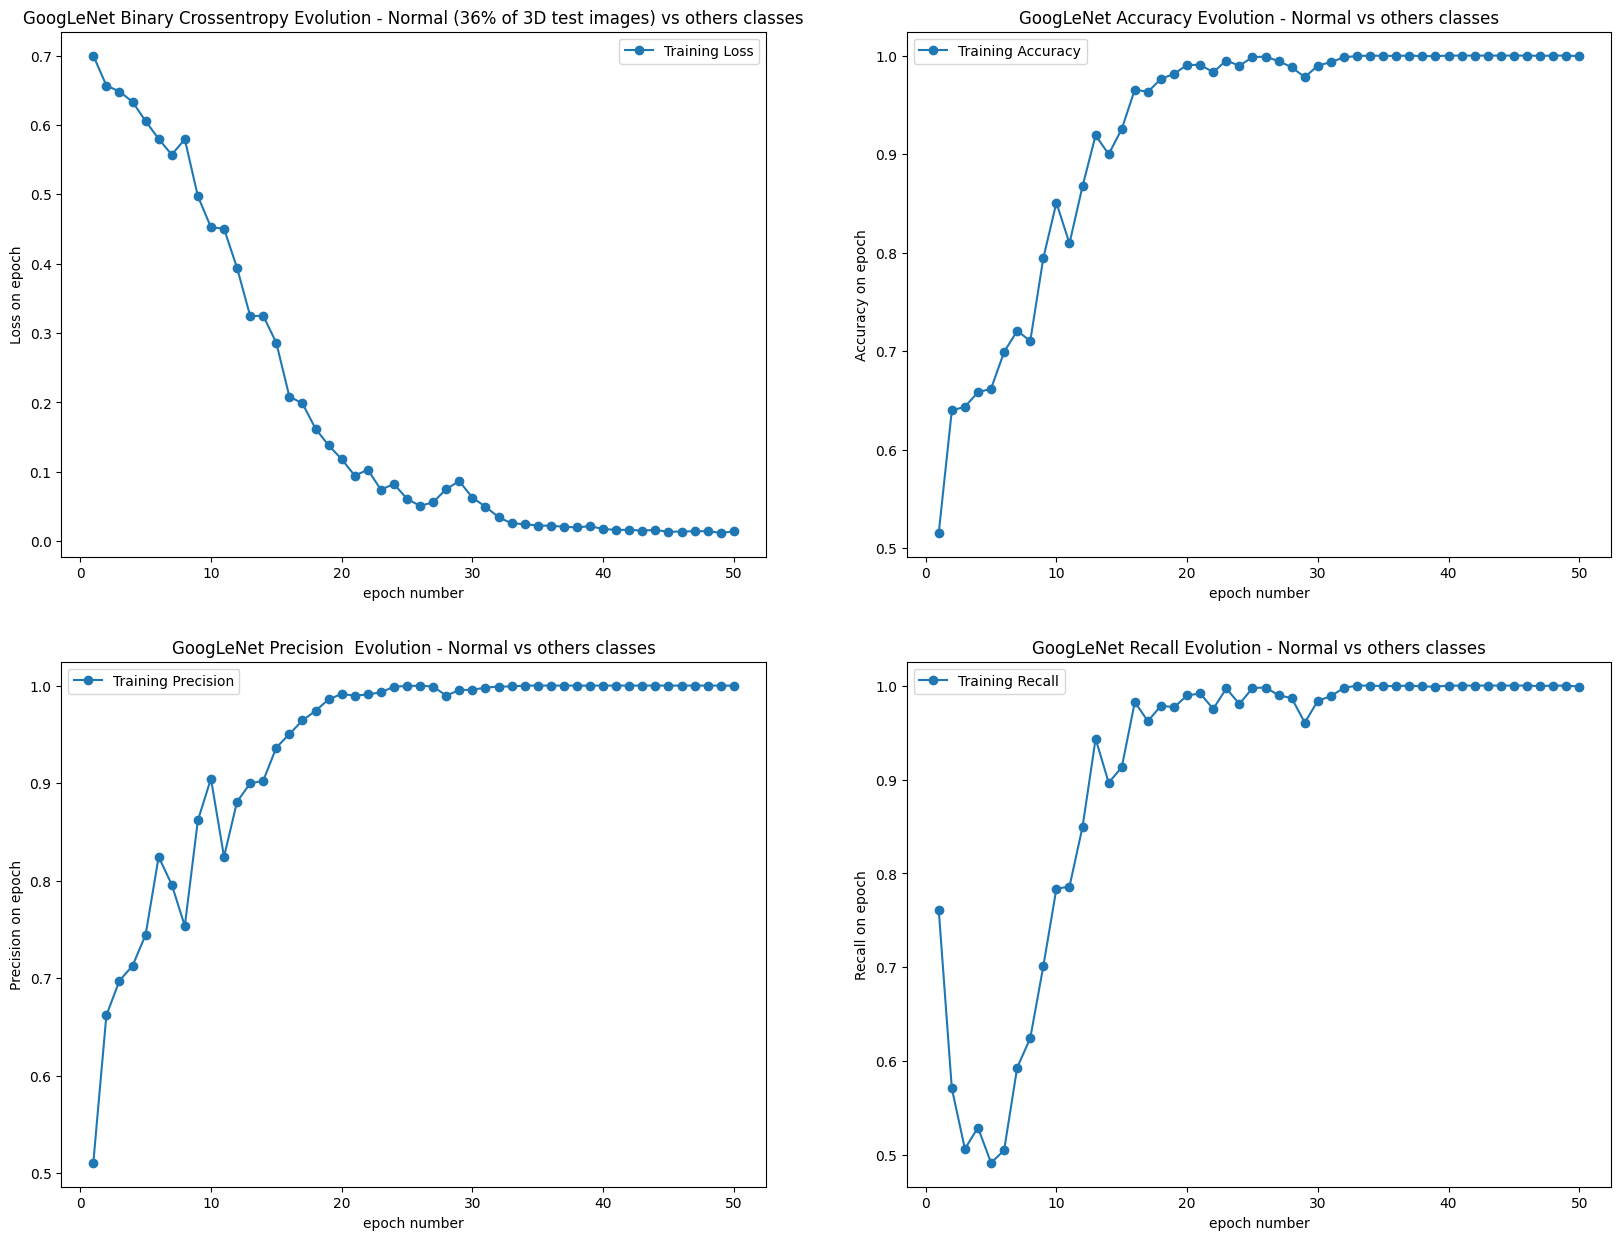

In [19]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(1, 51)), history.history['loss'], marker='o') 
plt.title('GoogLeNet Binary Crossentropy Evolution - Normal (36% of 3D test images) vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Loss on epoch') 
plt.legend(['Training Loss'])

plt.subplot(2, 2, 2)
plt.plot(list(range(1, 51)), history.history['accuracy'], marker='o') 
plt.title('GoogLeNet Accuracy Evolution - Normal vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Accuracy on epoch') 
plt.legend(['Training Accuracy'])

plt.subplot(2, 2, 3)
plt.plot(list(range(1, 51)), history.history['precision'], marker='o') 
plt.title('GoogLeNet Precision  Evolution - Normal vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Precision on epoch') 
plt.legend(['Training Precision'])

plt.subplot(2, 2, 4)
plt.plot(list(range(1, 51)), history.history['recall'], marker='o') 
plt.title('GoogLeNet Recall Evolution - Normal vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Recall on epoch') 
plt.legend(['Training Recall'])

In [20]:
predicts = []
binary_y = []
for x, y in zip(X_test, y_test):
    label = labels[x[-14:-4]]
    
    if y == 0:
        label = [1]
    else:
        label = [0]
        
    x = np.load(x)
    for i in range(x.shape[-2]+1):
        binary_y.append(label)
        
    x = np.array(separate_slices(x))
    predicts += (googlenet.predict(x, verbose=0).reshape(1,-1)[0]).tolist()

In [21]:
for i, x in enumerate(predicts):
    if predicts[i] > 0.5:
        predicts[i] = [1]
    else:
        predicts[i] = [0]

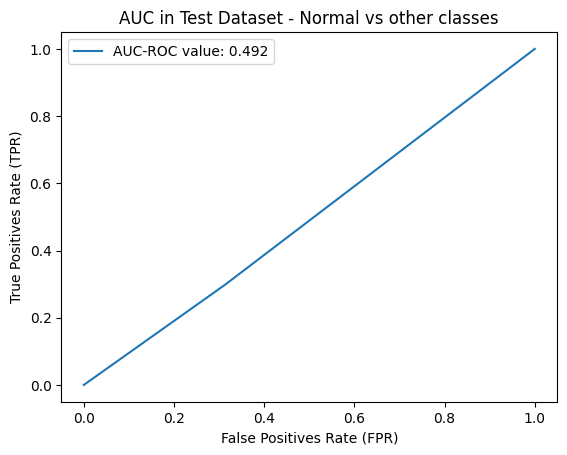

In [23]:
fpr, tpr, _ = roc_curve(predicts, binary_y)
auc = roc_auc_score(predicts, binary_y)
plt.xlabel('False Positives Rate (FPR)')
plt.ylabel('True Positives Rate (TPR)')
plt.title('AUC in Test Dataset - Normal vs other classes')
plt.plot(fpr,tpr)
plt.legend([f'AUC-ROC value: {round(auc, 3)}'])

[[1827  835]
 [ 364  155]]


<AxesSubplot: >

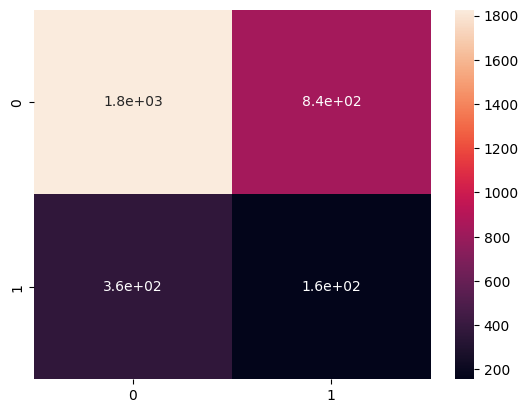

In [24]:
cm = confusion_matrix(predicts, binary_y)
print(cm)
heatmap(cm, annot=True)

In [25]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                   list_IDs=X_train, 
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                   dim_img=(192, 256), 
                                   batch_size=5,
                                   sub_batch_size=256,
                                   shuffle=True, 
                                   training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-5),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])
                                                               

# Train model on dataset
history = googlenet.fit(training_generator, epochs=50)

Epoch 1/50
35/35 [==============================] - 70s 1s/step - loss: 0.7004 - AUC: 0.4905 - accuracy: 0.4919 - precision: 0.4918 - recall: 0.5316
Epoch 2/50
35/35 [==============================] - 39s 1s/step - loss: 0.6796 - AUC: 0.6118 - accuracy: 0.5574 - precision: 0.6138 - recall: 0.3030
Epoch 3/50
35/35 [==============================] - 40s 1s/step - loss: 0.6800 - AUC: 0.6598 - accuracy: 0.5349 - precision: 0.6984 - recall: 0.1197
Epoch 4/50
35/35 [==============================] - 40s 1s/step - loss: 0.6558 - AUC: 0.7558 - accuracy: 0.5634 - precision: 0.8423 - recall: 0.1535
Epoch 5/50
35/35 [==============================] - 40s 1s/step - loss: 0.6635 - AUC: 0.7135 - accuracy: 0.5515 - precision: 0.7160 - recall: 0.1678
Epoch 6/50
35/35 [==============================] - 40s 1s/step - loss: 0.6419 - AUC: 0.7671 - accuracy: 0.5921 - precision: 0.8326 - recall: 0.2290
Epoch 7/50
35/35 [==============================] - 39s 1s/step - loss: 0.6088 - AUC: 0.8365 - accuracy: 0

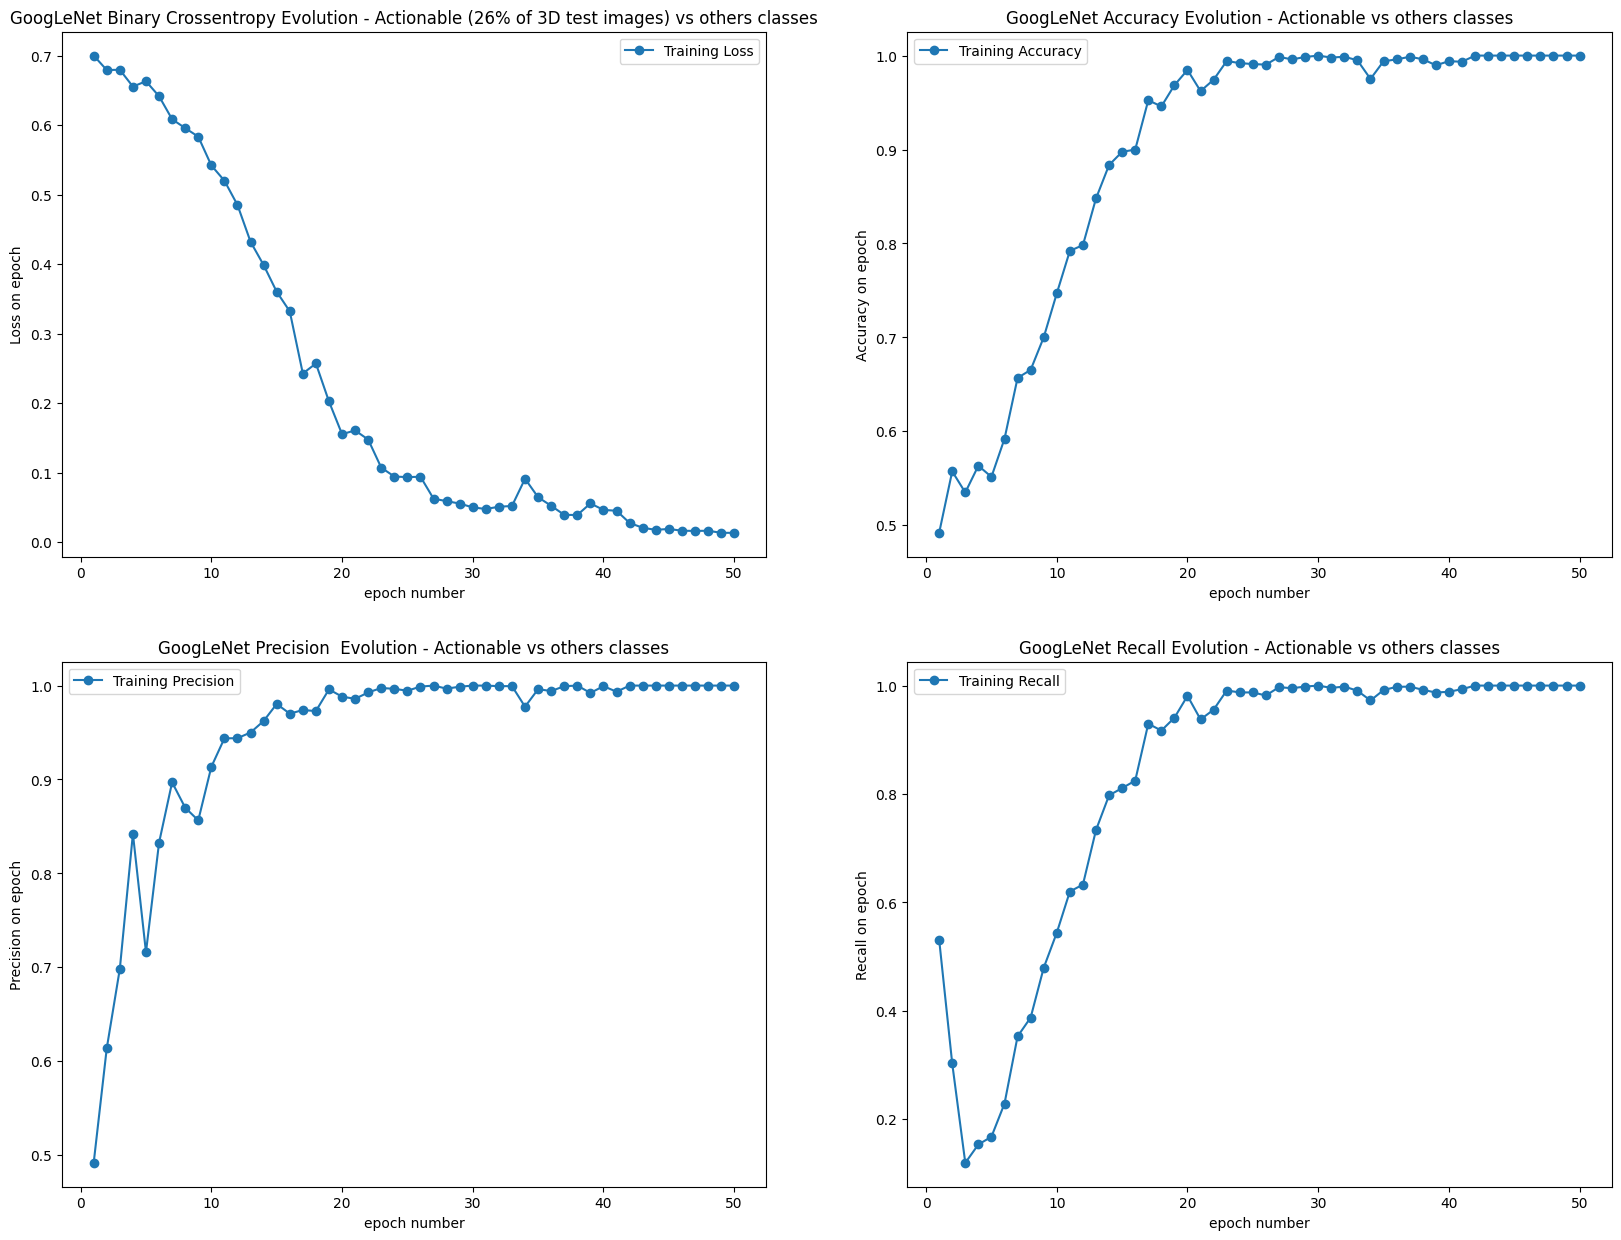

In [26]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(1, 51)), history.history['loss'], marker='o') 
plt.title('GoogLeNet Binary Crossentropy Evolution - Actionable (26% of 3D test images) vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Loss on epoch') 
plt.legend(['Training Loss'])

plt.subplot(2, 2, 2)
plt.plot(list(range(1, 51)), history.history['accuracy'], marker='o') 
plt.title('GoogLeNet Accuracy Evolution - Actionable vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Accuracy on epoch') 
plt.legend(['Training Accuracy'])

plt.subplot(2, 2, 3)
plt.plot(list(range(1, 51)), history.history['precision'], marker='o') 
plt.title('GoogLeNet Precision  Evolution - Actionable vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Precision on epoch') 
plt.legend(['Training Precision'])

plt.subplot(2, 2, 4)
plt.plot(list(range(1, 51)), history.history['recall'], marker='o') 
plt.title('GoogLeNet Recall Evolution - Actionable vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Recall on epoch') 
plt.legend(['Training Recall'])

In [27]:
predicts = []
binary_y = []
for x, y in zip(X_test, y_test):
    label = labels[x[-14:-4]]
    
    if y == 1:
        label = [1]
    else:
        label = [0]
        
    x = np.load(x)
    for i in range(x.shape[-2]+1):
        binary_y.append(label)
        
    x = np.array(separate_slices(x))
    predicts += (googlenet.predict(x, verbose=0).reshape(1,-1)[0]).tolist()

In [28]:
for i, x in enumerate(predicts):
    if predicts[i] > 0.5:
        predicts[i] = [1]
    else:
        predicts[i] = [0]

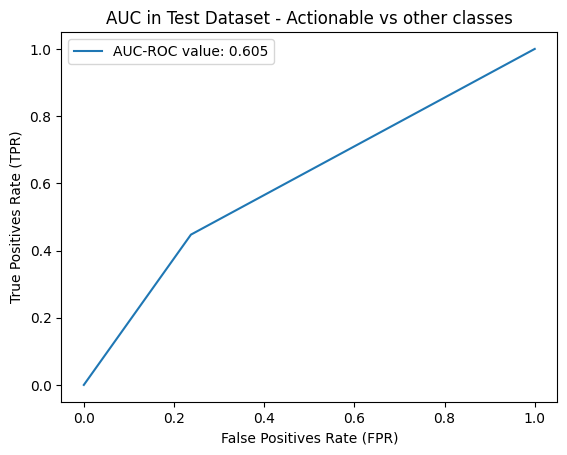

In [29]:
fpr, tpr, _ = roc_curve(predicts, binary_y)
auc = roc_auc_score(predicts, binary_y)
plt.xlabel('False Positives Rate (FPR)')
plt.ylabel('True Positives Rate (TPR)')
plt.title('AUC in Test Dataset - Actionable vs other classes')
plt.plot(fpr,tpr)
plt.legend([f'AUC-ROC value: {round(auc, 3)}'])

[[1868  582]
 [ 404  327]]


<AxesSubplot: >

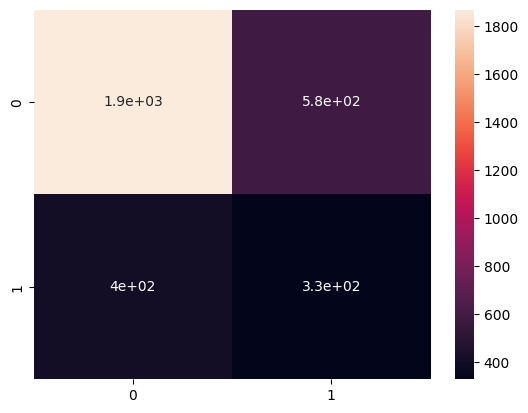

In [30]:
cm = confusion_matrix(predicts, binary_y)
print(cm)
heatmap(cm, annot=True)

In [31]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                   list_IDs=X_train, 
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                   dim_img=(192, 256), 
                                   batch_size=5,
                                   sub_batch_size=256,
                                   shuffle=True, 
                                   training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-5),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])
                                                               

# Train model on dataset
history = googlenet.fit(training_generator, epochs=50)

Epoch 1/50
35/35 [==============================] - 70s 1s/step - loss: 0.7045 - AUC: 0.4889 - accuracy: 0.4941 - precision: 0.4866 - recall: 0.2501
Epoch 2/50
35/35 [==============================] - 40s 1s/step - loss: 0.6748 - AUC: 0.6461 - accuracy: 0.5538 - precision: 0.6415 - recall: 0.2420
Epoch 3/50
35/35 [==============================] - 40s 1s/step - loss: 0.6523 - AUC: 0.7358 - accuracy: 0.5917 - precision: 0.7677 - recall: 0.2607
Epoch 4/50
35/35 [==============================] - 39s 1s/step - loss: 0.6306 - AUC: 0.8122 - accuracy: 0.6011 - precision: 0.8653 - recall: 0.2367
Epoch 5/50
35/35 [==============================] - 39s 1s/step - loss: 0.6063 - AUC: 0.8629 - accuracy: 0.6365 - precision: 0.9392 - recall: 0.2894
Epoch 6/50
35/35 [==============================] - 40s 1s/step - loss: 0.5879 - AUC: 0.8615 - accuracy: 0.6550 - precision: 0.9149 - recall: 0.3398
Epoch 7/50
35/35 [==============================] - 40s 1s/step - loss: 0.5572 - AUC: 0.8937 - accuracy: 0

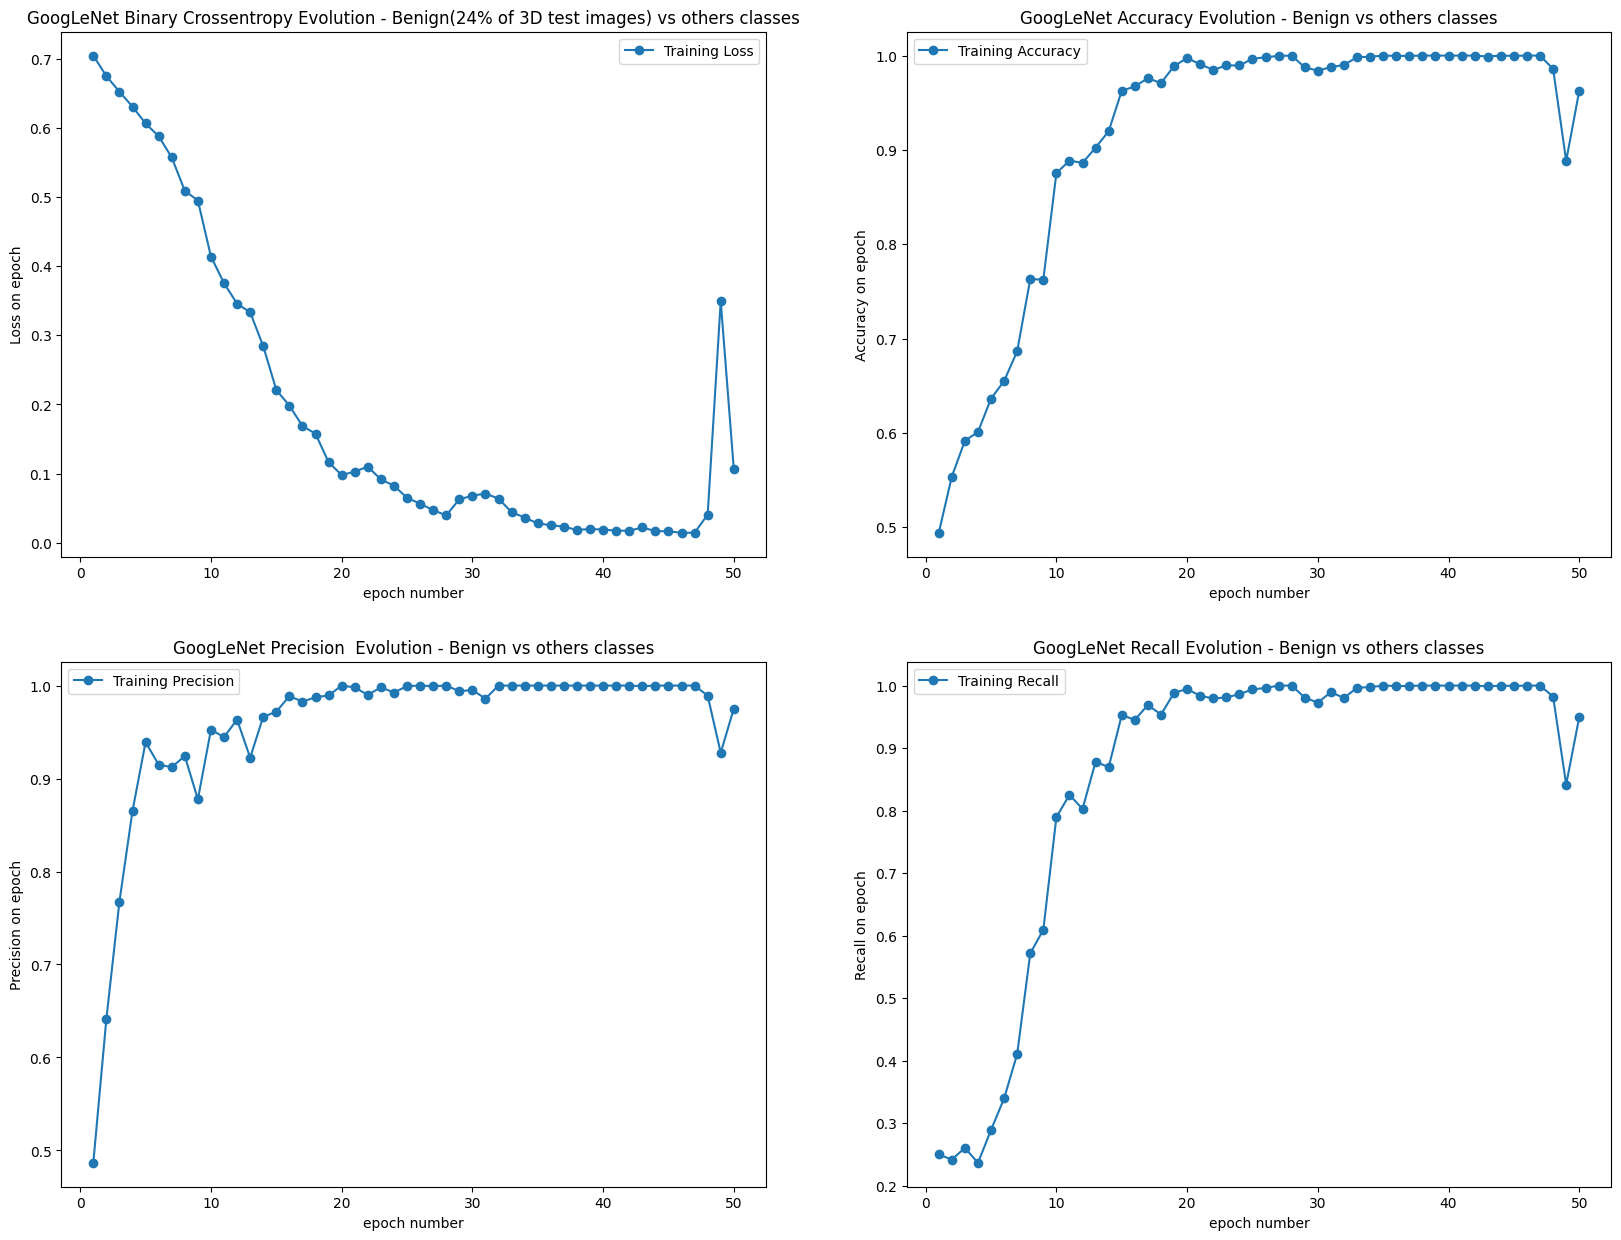

In [32]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(1, 51)), history.history['loss'], marker='o') 
plt.title('GoogLeNet Binary Crossentropy Evolution - Benign(24% of 3D test images) vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Loss on epoch') 
plt.legend(['Training Loss'])

plt.subplot(2, 2, 2)
plt.plot(list(range(1, 51)), history.history['accuracy'], marker='o') 
plt.title('GoogLeNet Accuracy Evolution - Benign vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Accuracy on epoch') 
plt.legend(['Training Accuracy'])

plt.subplot(2, 2, 3)
plt.plot(list(range(1, 51)), history.history['precision'], marker='o') 
plt.title('GoogLeNet Precision  Evolution - Benign vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Precision on epoch') 
plt.legend(['Training Precision'])

plt.subplot(2, 2, 4)
plt.plot(list(range(1, 51)), history.history['recall'], marker='o') 
plt.title('GoogLeNet Recall Evolution - Benign vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Recall on epoch') 
plt.legend(['Training Recall'])

In [33]:
predicts = []
binary_y = []
for x, y in zip(X_test, y_test):
    label = labels[x[-14:-4]]
    
    if y == 2:
        label = [1]
    else:
        label = [0]
        
    x = np.load(x)
    for i in range(x.shape[-2]+1):
        binary_y.append(label)
        
    x = np.array(separate_slices(x))
    predicts += (googlenet.predict(x, verbose=0).reshape(1,-1)[0]).tolist()

In [34]:
for i, x in enumerate(predicts):
    if predicts[i] > 0.5:
        predicts[i] = [1]
    else:
        predicts[i] = [0]

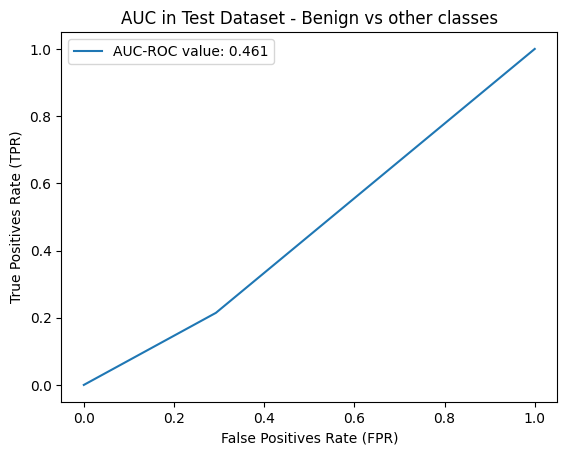

In [35]:
fpr, tpr, _ = roc_curve(predicts, binary_y)
auc = roc_auc_score(predicts, binary_y)
plt.xlabel('False Positives Rate (FPR)')
plt.ylabel('True Positives Rate (TPR)')
plt.title('AUC in Test Dataset - Benign vs other classes')
plt.plot(fpr,tpr)
plt.legend([f'AUC-ROC value: {round(auc, 3)}'])

[[1501  622]
 [ 831  227]]


<AxesSubplot: >

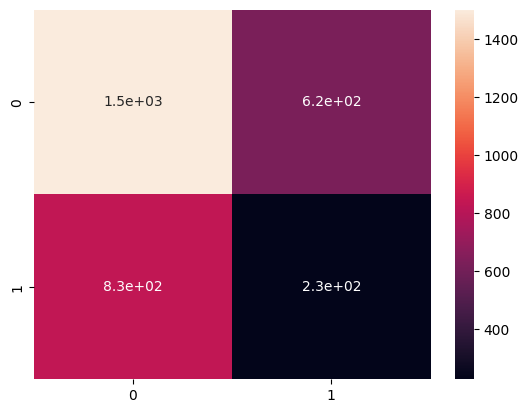

In [36]:
cm = confusion_matrix(predicts, binary_y)
print(cm)
heatmap(cm, annot=True)

In [37]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                   list_IDs=X_train, 
                                   labels_dir='/kaggle/input/labelsssssss/labels.csv', 
                                   dim_img=(192, 256), 
                                   batch_size=5,
                                   sub_batch_size=256,
                                   shuffle=True, 
                                   training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-5),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])
                                                               

# Train model on dataset
history = googlenet.fit(training_generator, epochs=50)

Epoch 1/50
35/35 [==============================] - 65s 1s/step - loss: 0.7126 - AUC: 0.4840 - accuracy: 0.5005 - precision: 0.4672 - recall: 0.0517
Epoch 2/50
35/35 [==============================] - 38s 1s/step - loss: 0.7228 - AUC: 0.5925 - accuracy: 0.5050 - precision: 0.6000 - recall: 0.0029
Epoch 3/50
35/35 [==============================] - 38s 1s/step - loss: 0.7333 - AUC: 0.6853 - accuracy: 0.5034 - precision: 1.0000 - recall: 7.9681e-04
Epoch 4/50
35/35 [==============================] - 38s 1s/step - loss: 0.7194 - AUC: 0.7858 - accuracy: 0.5036 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
35/35 [==============================] - 38s 1s/step - loss: 0.6925 - AUC: 0.8568 - accuracy: 0.5033 - precision: 1.0000 - recall: 0.0015
Epoch 6/50
35/35 [==============================] - 37s 1s/step - loss: 0.6723 - AUC: 0.8626 - accuracy: 0.5102 - precision: 1.0000 - recall: 0.0103
Epoch 7/50
35/35 [==============================] - 37s 1s/step - loss: 0.7138 - AUC: 0.8291 -

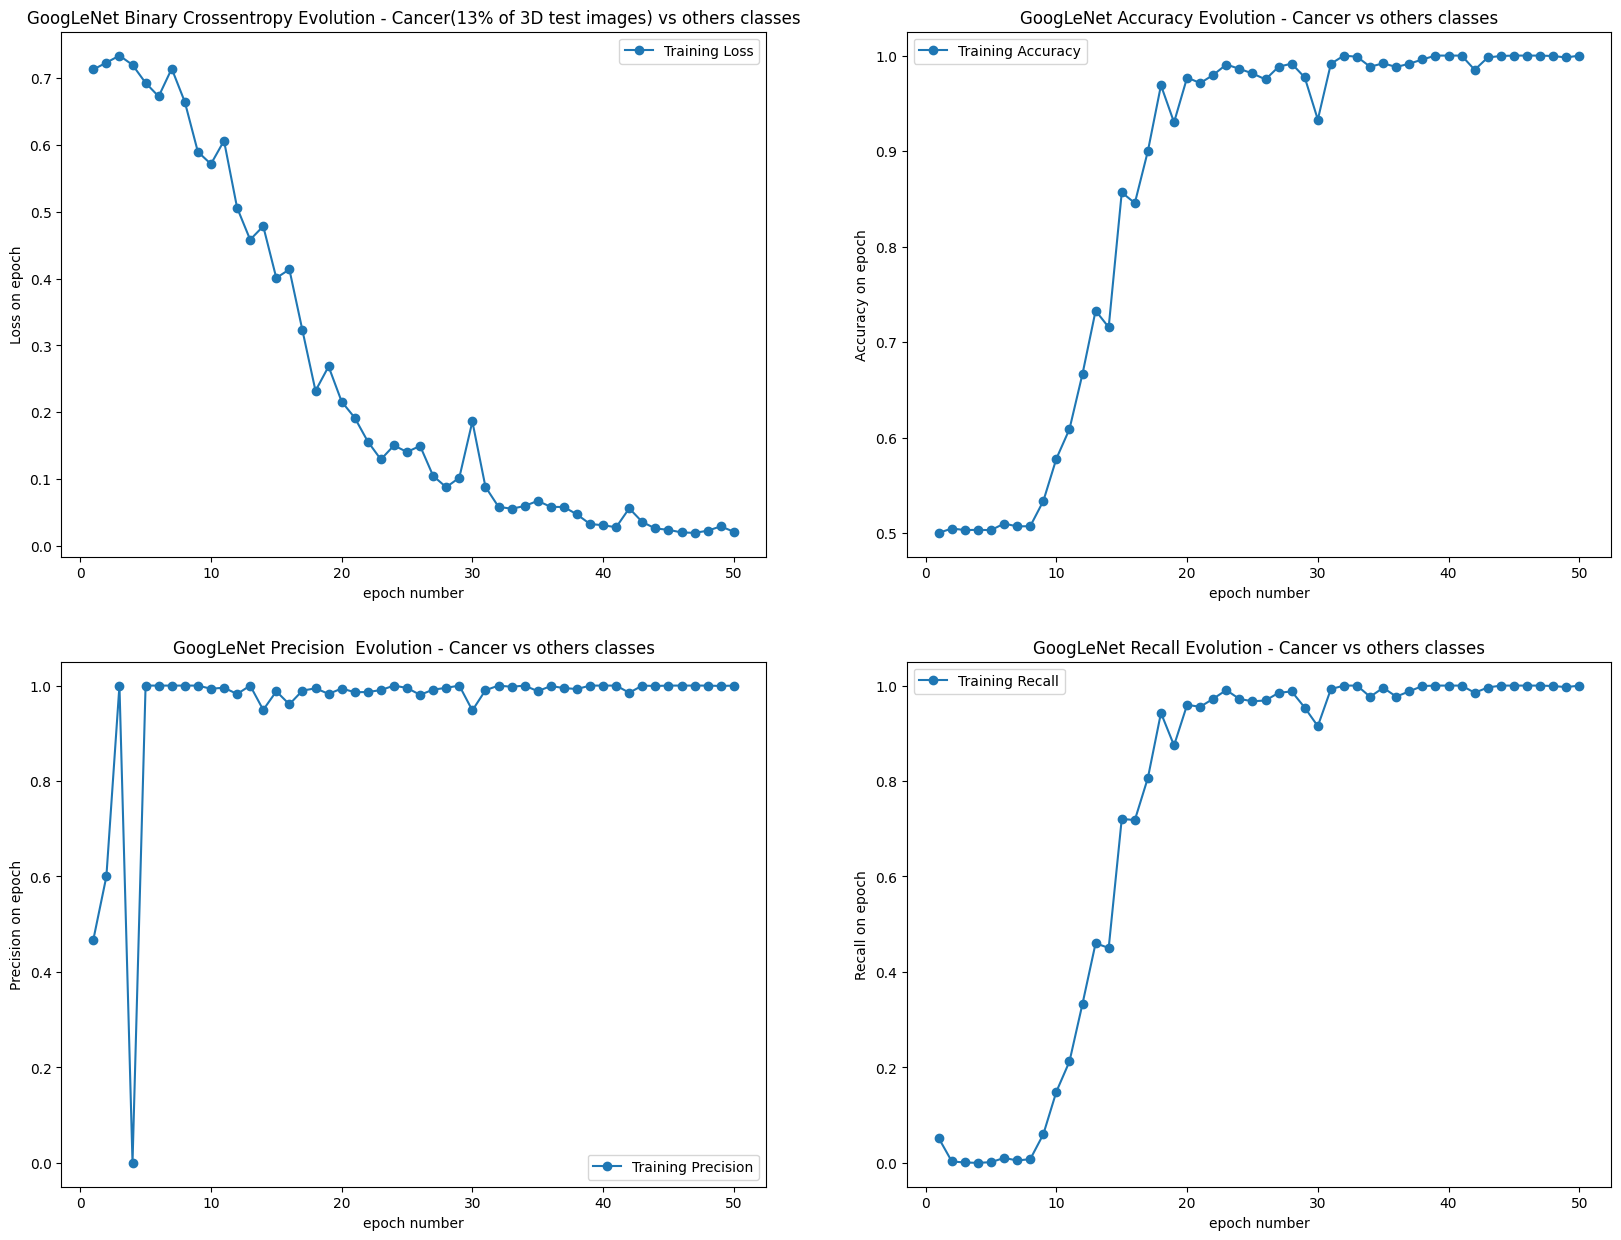

In [38]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(1, 51)), history.history['loss'], marker='o') 
plt.title('GoogLeNet Binary Crossentropy Evolution - Cancer(13% of 3D test images) vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Loss on epoch') 
plt.legend(['Training Loss'])

plt.subplot(2, 2, 2)
plt.plot(list(range(1, 51)), history.history['accuracy'], marker='o') 
plt.title('GoogLeNet Accuracy Evolution - Cancer vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Accuracy on epoch') 
plt.legend(['Training Accuracy'])

plt.subplot(2, 2, 3)
plt.plot(list(range(1, 51)), history.history['precision'], marker='o') 
plt.title('GoogLeNet Precision  Evolution - Cancer vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Precision on epoch') 
plt.legend(['Training Precision'])

plt.subplot(2, 2, 4)
plt.plot(list(range(1, 51)), history.history['recall'], marker='o') 
plt.title('GoogLeNet Recall Evolution - Cancer vs others classes') 
plt.xlabel('epoch number') 
plt.ylabel('Recall on epoch') 
plt.legend(['Training Recall'])

In [39]:
predicts = []
binary_y = []
for x, y in zip(X_test, y_test):
    label = labels[x[-14:-4]]
    
    if y == 3:
        label = [1]
    else:
        label = [0]
        
    x = np.load(x)
    for i in range(x.shape[-2]+1):
        binary_y.append(label)
        
    x = np.array(separate_slices(x))
    predicts += (googlenet.predict(x, verbose=0).reshape(1,-1)[0]).tolist()

In [40]:
for i, x in enumerate(predicts):
    if predicts[i] > 0.5:
        predicts[i] = [1]
    else:
        predicts[i] = [0]

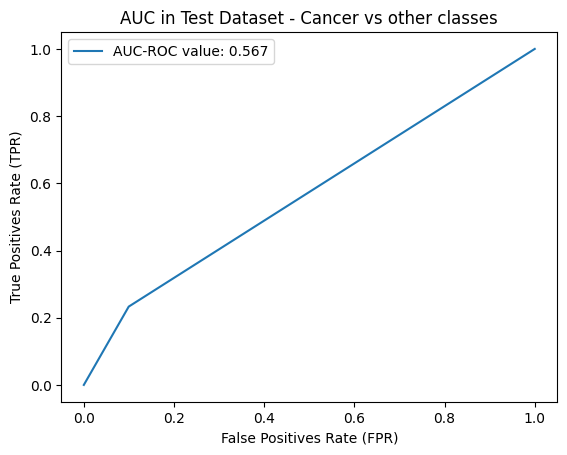

In [41]:
fpr, tpr, _ = roc_curve(predicts, binary_y)
auc = roc_auc_score(predicts, binary_y)
plt.xlabel('False Positives Rate (FPR)')
plt.ylabel('True Positives Rate (TPR)')
plt.title('AUC in Test Dataset - Cancer vs other classes')
plt.plot(fpr,tpr)
plt.legend([f'AUC-ROC value: {round(auc, 3)}'])

[[2080  230]
 [ 668  203]]


<AxesSubplot: >

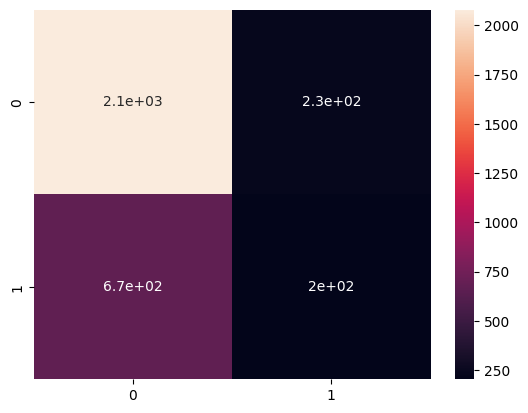

In [42]:
cm = confusion_matrix(predicts, binary_y)
print(cm)
heatmap(cm, annot=True)